# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [155]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from folium import folium, plugins
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, XGBClassifier
from IPython.display import HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 12

In [174]:
# binary encoding of violations
def binary_violations(violations_data):
    values_row = pd.Series([])
    if type(violations_data) == str:
        violations_data = violations_data.split(' | ')
        for violation in violations_data:
            index = "v" + violation.split('.')[0]
            values_row[index] = 1
    return values_row
# ===============================================PROCESSING==========================================================
# main processing utility
def clean_fix_encode():
    
    train_url = 'food-inspections-train.csv'
    test_url  = 'food-inspections-test.csv'

    train = pd.read_csv(train_url)
    test  = pd.read_csv(test_url)
    
    print("Initial Data: \nTrain data shape:", train.shape, '\n', "Test data shape:", test.shape)

    assert train.shape == (51916, 17)
    assert test.shape  == (17306, 17)
    
    train = train.drop(columns=["License #", 'DBA Name', 'Inspection Date',  'Location', "Address", "City", "State", "Zip", "Inspection ID"])
    test = test.drop(columns=["License #", 'DBA Name', 'Inspection Date', 'Location', "Address", "City", "State", "Zip",  "Inspection ID"])
    
    print("\n\n Dropped invalid License data : \n Train data shape:", train.shape, '\n', "Test data shape:", test.shape)
    
    train = train[~train.isin(["Out of Business", "Business Not Located", "No Entry"])]
    test = test[~train.isin(["Out of Business", "Business Not Located", "No Entry"])]
    
    print("\n\n Removed failed inspection entries : \n Train data shape:", train.shape, '\n', "Test data shape:", test.shape)
    
    print("\n\n Dropped inspection types that are not representative of normal business operations: \
           \n Train data shape:", train.shape, '\n', "Test data shape:", test.shape)
    
    train = train[train['Facility Type'].isin(["Restaurant", "Grocery Store"])]
    test = test[test['Facility Type'].isin(["Restaurant", "Grocery Store"])]
    
    print("\n\n Dropped inspection locations for hospitals and schools: \
           \n Train data shape:", train.shape, '\n', "Test data shape:", test.shape)  
    
    # ===============================================ENCODING==========================================================
    
    train['Violations'] = train['Violations'].str.extract('(\d+)', expand=False)
    test['Violations'] = test['Violations'].str.extract('(\d+)', expand=False)
    
    train['Violations'] = train['Violations'].astype(float)
    test['Violations'] = test['Violations'].astype(float)
    
    ce_binary = ce.BinaryEncoder(cols = ['Risk', 'Facility Type', 'AKA Name', 'Inspection Type'])
    train = ce_binary.fit_transform(train)
    test = ce_binary.transform(test)
    
    return train, test
    
train, test = clean_fix_encode()

train.head()


Initial Data: 
Train data shape: (51916, 17) 
 Test data shape: (17306, 17)


 Dropped invalid License data : 
 Train data shape: (51916, 8) 
 Test data shape: (17306, 8)


 Removed failed inspection entries : 
 Train data shape: (51916, 8) 
 Test data shape: (17306, 8)


 Dropped inspection types that are not representative of normal business operations:            
 Train data shape: (51916, 8) 
 Test data shape: (17306, 8)


 Dropped inspection locations for hospitals and schools:            
 Train data shape: (41168, 8) 
 Test data shape: (13729, 8)


,Risk_0,Risk_1,Risk_2,Facility Type_0,Facility Type_1,AKA Name_0,AKA Name_1,AKA Name_2,AKA Name_3,AKA Name_4,...,Inspection Type_1,Inspection Type_2,Inspection Type_3,Inspection Type_4,Inspection Type_5,Inspection Type_6,Violations,Latitude,Longitude,Fail
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,3.0,41.938007,-87.644755,1
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,32.0,41.772402,-87.683603,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,1,35.0,41.758779,-87.575054,0
3,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,38.0,41.812181,-87.707125,0
6,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,30.0,41.878531,-87.639427,0


# XGBOOST Model 
Okay, i'm going to be honest, either I accidentally made an incredible model, or im doing something very wrong to get such a high AUC ROC score.
Something bugging me is if the license number should be included? I tried to get some domain knowledge, I know I needed to drop the inspection number, because that's sort of seeing into the future. You cannot have an inspection number without the inspection taking place, but the license may or may not have pre-existed. 

## Edited

With the license # i get auc roc of .98

Without I get the same, so I guess it really does not matter too much

In [175]:
X = train.drop(columns=['Fail'])
y = train['Fail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = train.drop(columns='Fail')
y_train = train['Fail']

X_test = test.drop(columns='Fail')
y_test = test['Fail']

for i in range(1, 5):
    probs = XGBClassifier(max_depth=i, n_jobs=-1).fit(X_train, y_train).predict_proba(X_test)[:,1]
    print(i, "\t ROC AUC SCORE:", roc_auc_score(y_test, probs))

1 	 ROC AUC SCORE: 0.9849453018564835
2 	 ROC AUC SCORE: 0.9872808405917051
3 	 ROC AUC SCORE: 0.9894806644013623
4 	 ROC AUC SCORE: 0.9909534007868663


# Small visualization to get an idea of what the data looks like in the real world.

We can see some clustering, though we shouldn't harbor any assumptions about why right now

In [176]:
# Generate map
inspection_map = folium.Map([41.8600, -87.6298], zoom_start=10)

# Convert to (n, 2) nd-array format for heatmap
train_map = train.dropna()
inspections_sample = train_map.sample(10000)[["Latitude", "Longitude"]].values

# Plot heatmap
inspection_map.add_child(plugins.HeatMap(inspections_sample.tolist(), radius=10))

# Feature importance 

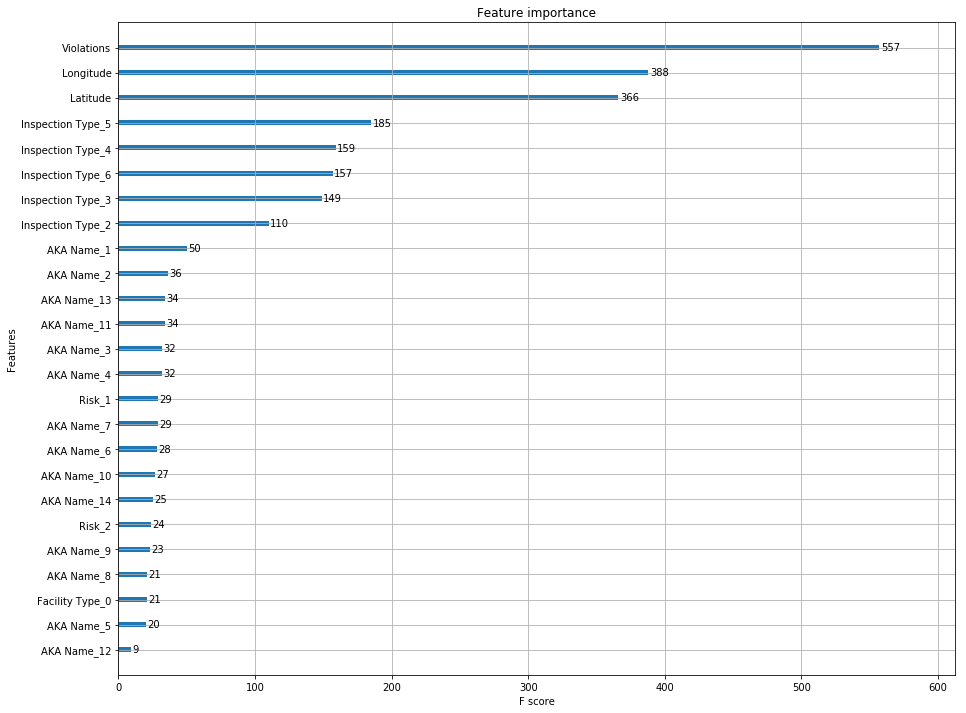

In [177]:
model = XGBClassifier(max_depth=5, n_jobs=-1).fit(X_train, y_train)
importances = model.feature_importances_

plot_importance(model)
plt.show()

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._